# Segmentação de Imagens de Trânsito

O objetivo deste exercicio é desenvolver um modelo de segmentação de imagens.

O dataset utilizado é o [CamSeq01](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamSeq01/), que possui apenas 101 imagens de alta resolução. Cada pixel é rotulado como uma de 32 classes (carro, pedestre, etc).

Existem apenas 71 imagens de treino e 30 de teste.

A métrica oficial é a DICE.

Dica de como calculá-la: https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i

### Download do Dataset

In [ ]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip .
!unzip CamSeq01.zip

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/CamSeq01.zip...
\ [1/1 files][ 90.3 MiB/ 90.3 MiB] 100% Done                                    
Operation completed over 1 objects/90.3 MiB.                                     
Archive:  CamSeq01.zip
   creating: CamSeq01/
  inflating: CamSeq01/.DS_Store      
  inflating: __MACOSX/CamSeq01/._.DS_Store  
   creating: CamSeq01/test/
  inflating: CamSeq01/label_colors.txt  
   creating: CamSeq01/train/
  inflating: CamSeq01/readme.txt     
  inflating: CamSeq01/test/0016E5_08137.png  
  inflating: CamSeq01/test/0016E5_08123.png  
  inflating: CamSeq01/test/0016E5_08139_L.png  
  inflating: CamSeq01/test/0016E5_08095.png  
  inflating: CamSeq01/test/0016E5_08141_L.png  
  inflating: CamSeq01/test/0016E5_08143_L.png  
  inflating: CamSeq01/test/0016E5_08097.png  
  inflating: CamSeq01/test/0016E5_08135.png  
  inflating: CamSeq01/test/0016E5_08121.png  
  inflating: CamSeq01/test/0016E5_08109.png  
  inflating: CamSeq01/test/0

In [ ]:
!pip install -q pytorch_lightning neptune-client==0.9.1

     |████████████████████████████████| 808kB 8.4MB/s 
     |████████████████████████████████| 215kB 15.8MB/s 
     |████████████████████████████████| 112kB 21.8MB/s 
     |████████████████████████████████| 829kB 18.0MB/s 
     |████████████████████████████████| 276kB 35.4MB/s 
     |████████████████████████████████| 645kB 36.0MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 174kB 51.7MB/s 
     |████████████████████████████████| 1.3MB 38.5MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 133kB 46.6MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 143kB 49.1MB/s 
     |████████████████████████████████| 296kB 51.5MB/s 


In [ ]:

import neptune.new as neptune

# Insira seu api_token para logar os resultados do treino na sua conta do Neptune.
# Como obter seu API token do Neptune:
# https://docs.neptune.ai/administration/security-and-privacy/how-to-find-and-set-neptune-api-token

run = neptune.init(project='mirelle/exercicio-8', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1MmI3M2JhMi03NDQ1LTQ1YmItOTFhMy1hZjRlZjRjYmMxZjUifQ==')

https://app.neptune.ai/mirelle/exercicio-8/e/EX4-31


In [ ]:
import os
from collections import OrderedDict
import h5py
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import Optimizer
from torch.autograd import Variable
from torch import nn

import torchvision
from torchvision import transforms

from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer


pl.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

### Estrutura da U-NET


#### Bloco básico

In [ ]:
# Arquitetura baseada no tutorial: https://amaarora.github.io/2020/09/13/unet.html


# blocos do encoder da u-net. 
# Possui duas convuloções, que irá reduzir o tamanho da imagem pela metade. Cada convolução deve ser seguida por uma camada de ativação relu.
# No paper ele diz que a conv deve receber kernel de tamanho = 3
# Aléém diss, o mapa de recursos de saída não tem a mesma altura e largura que o mapa de recursos de entrada, pois, a operação éé feita sem pad.
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))


#Testando a camada
# A imagem deve reduzir seu tamanho para 64
enc_block = Block(1, 64)
x = torch.randn(1, 1, 572, 572)
enc_block(x).shape



torch.Size([1, 64, 568, 568])

#### Enconder
> Each block is followed by a 2x2 max pooling operation with stride 2 for downsampling.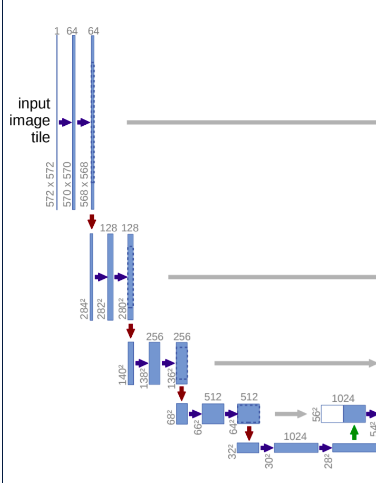

In [ ]:
 
 # Ainda nãão estamos fazendo a parte da redução da resolução da imagem. 
 # A parte de redução é feita pela operação max_pooling

class Encoder(nn.Module):
    #chs = tamanho de canais que a imagem irá passar pela etapa de enconder (como na imagem)
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        # a operação irá se repedir por cada tamanho de canal iterativamente 
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []

        for block in self.enc_blocks:
            # Após a cada iteração, a operação max_pooling é aplicada, para reduzir a resolução da imagem
            x = block(x)
            # A saída de cada iteração é reservada para realizar depois a concatenação com a etapa de decoder
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


#Testado o bloco de enconder

encoder = Encoder()
# input image , imagemde 3 canais e resoluçã de 572
x = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: 
  # enquanto o número de canais aumenta, o número de resolução cai!
  print(ftr.shape)



torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


#### Decoder
> Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.


> No pytorch existe a operação "ConvTranspose2d" que faz o  “up-convolution”.


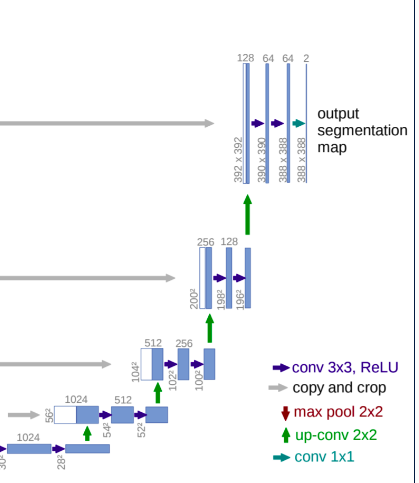



In [ ]:

class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs = chs
        # O aumento de resolução proposta no paper pode ser feita via ConvTranspose2d ( que divide pela metade o número de canais de características)
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        # Depois o resultado de cada concatenamento, irá para block() que iráá fazer 2convs seguido pela RELU
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            #Operação ConvTranspose2d para todos os canais
            x  = self.upconvs[i](x)
            # Agora éé feito um recorte. Ele é necessário evido a perda de pixels da borda da conv (lembrando que nestas operações não há pad)
            enc_ftrs = self.crop(encoder_features[i], x)
            #Concatena com o resultado do enconder
            x = torch.cat([x, enc_ftrs], dim=1)
            x   = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape # (1,chanels,height,wight)
        #faz o crop, passando a altura e largura da imagem.
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


#Validando a função

decoder = Decoder()

x = torch.randn(1, 1024, 28, 28)
# ftrs etapa de encoder
# ftrs[::-1][1:] = não considera a ultima iteraçãão do encoder (torch.Size([1, 1024, 28, 28])) pq ele nunca éé concatenado
# é  feito apenas a operação upsampling. 
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

### Jutando os pontos

> Para finalizar, deve apenas juntar o enconder do decoder. e inserira uma camada de conv para classificar os pixels nas classes propostas

> interpolate é utilizado para tornar o tamanho de saída igual ao tamanho da imagem de entrada. Lembrando que por não usar pad, o tamanho da imagem de saíída nunca iráá ser igual a de entrada.

In [ ]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=True, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.out_sz = out_sz
        # head faria a etapa de "classificação" como na imagem
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out



#Testando
unet = UNet()
x = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 572, 572])

### Dice Loss

In [ ]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth = 1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self,y_pred, y_true,):
        num_classes = y_pred.shape[1]
        y_pred = torch.softmax(y_pred, dim=1) # probabilidades para cada classe

        # a loss é calculada pra cada classe e somada
        loss = 0
        for c in range(num_classes):
            pred_c = y_pred[:,c,:,:].contiguous().view(-1) # probabilidades da classe c
            true_c = 1*(y_true == c).contiguous().view(-1)      # =1 para valores da classe c
            
            inter = (pred_c * true_c).sum()
            loss += (2 * inter + self.smooth) / (pred_c.sum() + true_c.sum() + self.smooth)
 
        return loss

## Dataset e Dataloader

In [ ]:
def get_dict(file_name):
  dictionary = {}

  with open(file_name) as file:
    for line in file:
        (px1, px2,px3, label) = line.split()
        dictionary[label] = [int(px1),int(px2),int(px3)]
  return  OrderedDict(dictionary)




color_codes = get_dict('/content/CamSeq01/label_colors.txt')

In [ ]:
class CamSeqDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_dir, 
                 color_codes=color_codes,
                 transforms=None):
        
        super().__init__()
      
        self.images,self.masks = self.get_image_mask(img_dir)
        self.color_codes = color_codes
        self.transforms = transforms
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long
  
    def get_image_mask(self, img_dir):
      mask_images = []
      images = []
      for img in os.listdir(img_dir):
        if img.split('.')[0].endswith('_L'):
          mask_images.append(os.path.join(img_dir,img))
        else:
          images.append(os.path.join(img_dir,img))
      return sorted(images), sorted(mask_images)
        
    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, idx):
        
        img = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        
        if img.mode != 'RGB':
            img = img.convert('RGB')
        if mask.mode != 'RGB':
            mask = mask.convert('RGB')
            
        img = np.asarray(img)
        mask = np.asarray(mask)
        mask_channels = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
        
        for i, cls in enumerate(self.color_codes.keys()):
            color = self.color_codes[cls]
            sub_mask = np.all(mask==color, axis=-1)*i
            mask_channels += sub_mask #*i

        if self.transforms is not None:
          img  = self.transforms(img)
          mask_channels = transforms.Compose([
                                      torchvision.transforms.ToTensor(),
                                      transforms.Resize(size=(224, 224)),
                                    ])(mask_channels)
       
        #transforma [1, H, W] = [H, W]
        label =  mask_channels.transpose(2,0).squeeze(-1)

        #image, mask
        return img.float(), label.long()


class CamSeqDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 50, num_workers: int = 2):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Resize(size=(224, 224)),
              transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                  
    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
          full_dataset = CamSeqDataset('/content/CamSeq01/train', transforms=self.transform)
          train_size = int(len(full_dataset)*0.80)
          self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, len(full_dataset)-train_size])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.test_dataset =  CamSeqDataset('/content/CamSeq01/test',transforms=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [ ]:
dm = CamSeqDataModule(batch_size=3)
# To access the x_dataloader we need to call prepare_data and setup.
dm.setup()

x, y = next(iter(dm.train_dataloader()))

print(x.shape)
print(y.shape)

torch.Size([3, 3, 224, 224])
torch.Size([3, 224, 224])


## Treinamento

In [ ]:
class UNetModel(pl.LightningModule):
    def __init__(self, hparams, out_size, num_classes=2):
        super().__init__()
        
        self.params = hparams
        self.best_valid_loss = 10e9
        self.num_classes = num_classes
        self.criterion = torch.nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()
        self.out_size = out_size

        # Instanciando modelo
        self.model = UNet(num_class = self.num_classes, out_sz=self.out_size)        
       
    # returns the feature tensor from the model
    def _forward_features(self, x):
        out = self.model(x)
        return out
    
    # will be used during inference
    def forward(self, x):
      preds = self.model(x)
      return preds

    def training_step(self, train_batch, batch_idx):
      x, y = train_batch

      preds = self.model(x)

      # calcula a perda
      batch_losses = self.criterion(preds, y)
      #loss = batch_losses.mean()
      run['train/batch_loss'].log(batch_losses)

      # O PL sempre espera um retorno nomeado 'loss' da training_step.
      return {'loss': batch_losses, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        self.log('train_loss', avg_loss, on_epoch=True, prog_bar=True)
        
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        # predict da rede
        preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(preds, y)

        #Durante a etapa de avaliçãão, não se deseja minimizar a dice loss
        batch_dice_loss = self.dice_loss(preds, y)
        #1. + self.criterion(y, preds)
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_dice': batch_dice_loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        dice = torch.stack([output['batch_dice'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/dice'].log(dice)

        metrics = {'valid_loss': avg_loss.item(), 'dice': dice.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}

        #salva o melhor modelo
               
        if avg_loss < self.best_valid_loss:
            torch.save(self.model.state_dict(), '/best_model_Unet.pt')
            self.best_valid_loss = avg_loss
        torch.save(self.model.state_dict(), '/trainer_model_Unet.pt')


        self.log('validate_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('validate_dice', dice, on_epoch=True, prog_bar=True)
        return output
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
      
        preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(preds, y)
             
        # calcula dice loss se a remoção do 1
        batch_dice = self.dice_loss(preds, y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_dice': batch_dice}
    

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        dice = torch.stack([output['batch_dice'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/dice'].log(dice)

        metrics = {'Test loss': avg_loss.item(), 'test dice': dice.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('test_dice', dice,  on_epoch=True, prog_bar=True)
        return output

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['learning_rate'])

        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

In [ ]:
# definindo os hyperparametros
hparams = {
    'max_epochs': 30,
    'learning_rate': 0.001,
    
}

#init 
dm = CamSeqDataModule(batch_size=50)
# To access the x_dataloader we need to call prepare_data and setup.
dm.setup()

#init model
pl_model = UNetModel(hparams=hparams, num_classes=len(color_codes), out_size = (224, 224))

# Initialize a trainer
trainer = pl.Trainer(max_epochs=hparams['max_epochs'],
                     progress_bar_refresh_rate=1,
                     accumulate_grad_batches = 1,
                     gpus=1, 
                     log_every_n_steps=1) 
              
# Train the model ⚡🚅⚡
trainer.fit(pl_model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | dice_loss | DiceLoss         | 0     
2 | model     | UNet             | 31.0 M
-----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.135   Total estimated model params size (MB)


Global seed set to 123


In [ ]:
# continuar o treinamento
trainer = pl.Trainer(max_epochs=15,
                     progress_bar_refresh_rate=1,
                     accumulate_grad_batches = 1,
                     gpus=1, 
                     log_every_n_steps=1) 
              
# Train the model ⚡🚅⚡
trainer.fit(pl_model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | dice_loss | DiceLoss         | 0     
2 | model     | UNet             | 31.0 M
-----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.135   Total estimated model params size (MB)


Global seed set to 123


Experiencing connection interruptions. Reestablishing communication with Neptune.


Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stderr : Text longer than 1000 characters was truncated


## Avaliação

In [ ]:
# ideia do aluno Pedro
def calculate_dice(model, dataloader):
    model.eval()
    dataloader.shuffle = False
    dice_per_class = []
    total = 0

    for x, y in dataloader:
        pred = model.model.forward(x)
        pred = pred.argmax(dim=1)

        for k in range(len(color_codes)):
            d0 = 2 * (pred[y == k] == k).sum()
            d1 = ((pred[pred == k] == k).sum() + (y[y == k] == k).sum())
            if d0 != 0 and d1 != 0:
                dice_per_class.append(d0 / d1)

    return sum(dice_per_class) / len(dice_per_class)

d_test = calculate_dice(pl_model, dm.test_dataloader())
d_val = calculate_dice(pl_model, dm.val_dataloader())
d_train = calculate_dice(pl_model, dm.train_dataloader())


print('Test Dice =', d_test)
print('Validation Dice =', d_val)
print('Train Dice =', d_train)

Test Dice = tensor(0.2362)
Validation Dice = tensor(0.3881)
Train Dice = tensor(0.3725)
